In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, text
from sqlalchemy.orm import declarative_base

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement

# the station class to a variable called `Station`
Station= Base.classes.station

In [8]:
# Create a session
session = Session(engine)

inspector = inspect(engine)
columns = inspector.get_columns('Measurement')
for c in columns:
        print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(lastdate)

('2017-08-23',)


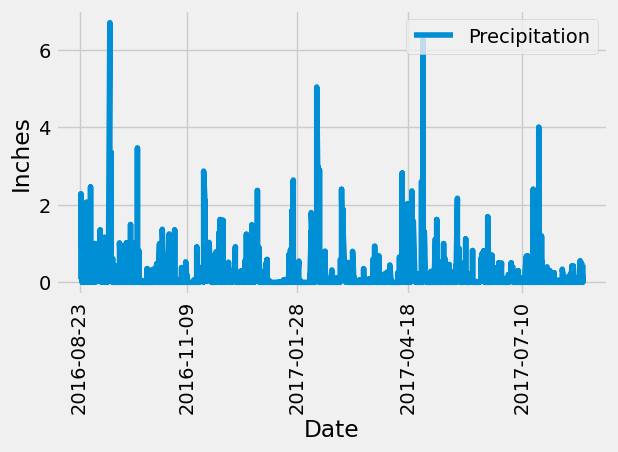

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
lastdate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
#converting last date from string
lastdate = dt.datetime.strptime(lastdate, '%Y-%m-%d')
# Calculate the date one year from the last date in data set.
firstdate= lastdate-dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= firstdate).filter(Measurement.date <= lastdate).all()
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns=['Date', 'Precipitation'])
precip_df = precip_df.dropna(subset=['Precipitation'])
# Sort the dataframe by date
#convert Date column to datetime
precip_df['Date'] = pd.to_datetime(precip_df['Date'])
sorted_precip_df= precip_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(sorted_precip_df['Date'], sorted_precip_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)  
# Reducing the number of ticks
custom_ticks = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
#convert to dt format
custom_ticks = pd.to_datetime(custom_ticks)
plt.xticks(custom_ticks, rotation=90)
plt.legend(loc='upper right') 
plt.tight_layout()


In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_precip_df['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.id)).all()

[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
allthestations = session.query(Station.station, func.count(Station.station)).\
    join(Measurement, Station.station == Measurement.station).\
    group_by(Station.station).order_by(func.count(Station.station).desc()).all()

for station, count in allthestations:
    print(f"Station: {station}, Observations: {count}")

Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_data = session.query(
    func.min(Measurement.tobs),   
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)    
).filter(Measurement.station == 'USC00519281').all()

min_temp, max_temp, avg_temp = temp_data[0]
temp_data

[(54.0, 85.0, 71.66378066378067)]

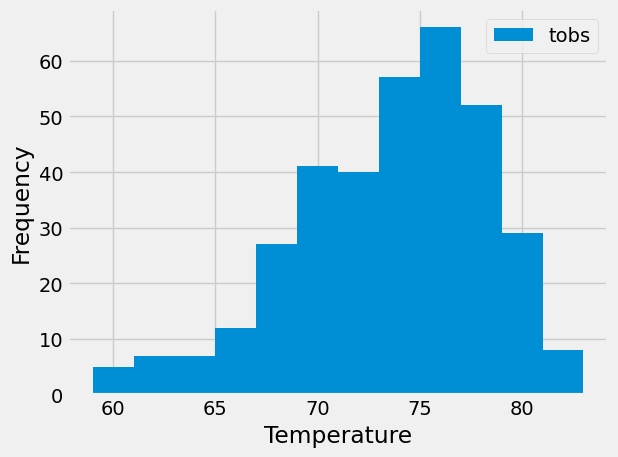

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_date_tobs = session.query(Measurement.date).\
        filter(Measurement.station == 'USC00519281').order_by(Measurement.date.desc()).first()[0]
# convert to dt
last_date_tobs = dt.datetime.strptime(last_date_tobs, '%Y-%m-%d')

#calculate one year before that
first_date_tobs= last_date_tobs - dt.timedelta(days=365)
        
#New query for all data from most active station & from most recent year of data for that station
popular_tobs=session.query(Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= firstdate).filter(Measurement.date <= lastdate).all()

#Put it into pandas
popular_tobsdf = pd.DataFrame(popular_tobs, columns=['tobs'])

#Ploting season - use some bins (12 to be exact)

plt.hist(popular_tobsdf['tobs'], bins=12, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


# Close Session

In [16]:
# Close Session
session.close()
